In [55]:
#Для создания глубоких копий составных объектов
from copy import deepcopy

import os, gc
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score,train_test_split, KFold

from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from bayes_opt import BayesianOptimization

from pylightgbm.models import GBMRegressor
os.environ['LIGHTGBM_EXEC'] = "/home/konstantin/program_files/LightGBM/lightgbm" #здесь ты должен указать свой путь к GBM

import xgboost as xgb

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import rainbow

In [2]:
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings('ignore')

**1. Предобработка данных. Что в них есть интересного?**

**2. Скоринг человека.**
Нужно предсказать, сколько раз человек посетит врача (target).

**3. Балансировка участков на скоринговой модели.**
Необходимо,чтобы модель была интерпретируемая(набор четких правил, понятный врачу).

In [3]:
sc_data = pd.read_csv('hackaton_scoring_data.csv',sep=';')

In [4]:
sc_data.head()

,untouchable,pat_id,lpu_district,pers_district,MOSCOW_REGISTRATION,invalid,nadomnik,age_calculate_y,sovmest_deti,sovmest_lgotnik,...,bezrab_дело на рассмотрении,COMMON_GENDER,lux1,lux2,FLAG_BESSR,HAD_APPOINTMENTS,from_region,lpu_id,district_id,target
0,NaN,0,0,0,1.0,0.0,0.0,47,0,0,...,0,0.0,0,0,0,0.0,0.0,2,38,12.0
1,NaN,224,0,0,1.0,0.0,0.0,50,1,1,...,0,1.0,0,0,1,1.0,0.0,2,106,19.0
2,NaN,344,0,0,1.0,1.0,0.0,50,0,0,...,0,0.0,0,0,0,1.0,0.0,2,96,24.0
3,NaN,370,0,0,1.0,0.0,0.0,18,2,3,...,0,1.0,0,0,0,0.0,0.0,2,38,13.0
4,NaN,445,0,0,1.0,0.0,0.0,49,1,0,...,0,0.0,0,0,1,1.0,0.0,2,106,13.0


### Общее число пациентов, обратившихся  в поликлинику  

In [5]:
len(sc_data)

967044

In [6]:
# Число уникальных pat_id -- число уникальных пациентов
sc_data['pat_id'].nunique()

966874

In [7]:
sc_data.shape

(967044, 27)

In [8]:
sc_data.shape[0] - sc_data['pat_id'].nunique()

170

### Число одинаковых строк в исходной таблице данных<=> число клонов 

In [9]:
np.sum(sc_data.duplicated())

101

Прикол конечно, но в таблице 101 дубликат.

In [10]:
col_names = np.array(sc_data.columns)

In [11]:
col_names[11] = 'sphere_new_School' #признак -- работник образования
col_names[12] = 'sphere_new_hospital' #признак -- работник здравохранения
col_names[13] = 'sphere_new_sotszaschita' #признак -- соц работник 
col_names[14] = 'sphere_ZHKH' ##работник ЖКХ
col_names[15] = 'bezrab_now'
col_names[16] = 'bezrab_2015'
col_names[17] = 'bezrab_may_be'

In [12]:
sc_data.columns = col_names

In [13]:
sc_data.dtypes

untouchable                float64
pat_id                       int64
lpu_district                 int64
pers_district                int64
MOSCOW_REGISTRATION        float64
invalid                    float64
nadomnik                   float64
age_calculate_y              int64
sovmest_deti                 int64
sovmest_lgotnik              int64
sovmest_pens                 int64
sphere_new_School            int64
sphere_new_hospital          int64
sphere_new_sotszaschita      int64
sphere_ZHKH                  int64
bezrab_now                   int64
bezrab_2015                  int64
bezrab_may_be                int64
COMMON_GENDER              float64
lux1                         int64
lux2                         int64
FLAG_BESSR                   int64
HAD_APPOINTMENTS           float64
from_region                float64
lpu_id                       int64
district_id                  int64
target                     float64
dtype: object

все признаки имеют числовые значения

In [14]:
ufo_indexes = sc_data.groupby('pat_id').size()[sc_data.groupby('pat_id').size()>1]
#индексы повторяшки (как известно в базах данных индексы должны быть уникальными, 
# в нашем случае мы имееем противное

#какие-то пациенты встречаются 2 раза, какие-то 4 раза
ufo_indexes.unique()

array([2, 4])

In [15]:
#Число индексов повторяшек 
len(ufo_indexes)

168

In [16]:
#Число индексов повторяшек без учёта абсолютных дубликатов
len(ufo_indexes) - np.sum(sc_data.duplicated())

67

### Есть ли Nan?

In [17]:
np.sum(pd.isnull(sc_data)) #количество пропущенных значений в каждом столбце

untouchable                756068
pat_id                          0
lpu_district                    0
pers_district                   0
MOSCOW_REGISTRATION             0
invalid                         0
nadomnik                        0
age_calculate_y                 0
sovmest_deti                    0
sovmest_lgotnik                 0
sovmest_pens                    0
sphere_new_School               0
sphere_new_hospital             0
sphere_new_sotszaschita         0
sphere_ZHKH                     0
bezrab_now                      0
bezrab_2015                     0
bezrab_may_be                   0
COMMON_GENDER                   0
lux1                            0
lux2                            0
FLAG_BESSR                      0
HAD_APPOINTMENTS                0
from_region                     0
lpu_id                          0
district_id                     0
target                          0
dtype: int64

### Таким образом, пропуски есть только в untouchable

## Отношение пациентов к смене участка

In [18]:
for value in sc_data['untouchable'].unique():
    if np.isnan(value):
        print(str(value) + '  ' + str(np.sum(np.isnan(sc_data['untouchable']))))
    else:
        print(str(value) + '  ' + str(np.sum(sc_data['untouchable']==value)))

nan  756068
0.0  196459
1.0  14517


В основном про людей не известно, как они отнесутся к переходу к другому участку.

Видется 4 пути замены nan:
1. nan = 0, если они не возмущаются их можно переселять хоть на марс(простой выход и выгодный, чем больше людей можно переносить, тем больше у нас свободы действий)
2. nan = 1, если они не согласились, значит не будем их трогать(наихудший для нас вариант и для людей)
3. nan = 2 -- ввод класса затрудняющихся c выбором
4. Построить по имеющимся данным классификатор, который относит nan'ов к 0 или 1.    



In [19]:
def num_cat(data):
    for name in data.columns:
        print(str(name) + ':' + ' '+ str(data[name].nunique()))
#Количество уникальных значений
num_cat(sc_data)

untouchable: 2
pat_id: 966874
lpu_district: 46
pers_district: 140
MOSCOW_REGISTRATION: 2
invalid: 2
nadomnik: 2
age_calculate_y: 104
sovmest_deti: 44
sovmest_lgotnik: 65
sovmest_pens: 26
sphere_new_School: 2
sphere_new_hospital: 2
sphere_new_sotszaschita: 2
sphere_ZHKH: 2
bezrab_now: 2
bezrab_2015: 2
bezrab_may_be: 2
COMMON_GENDER: 2
lux1: 2
lux2: 2
FLAG_BESSR: 2
HAD_APPOINTMENTS: 2
from_region: 2
lpu_id: 22
district_id: 479
target: 60


# Корреляционная карта.

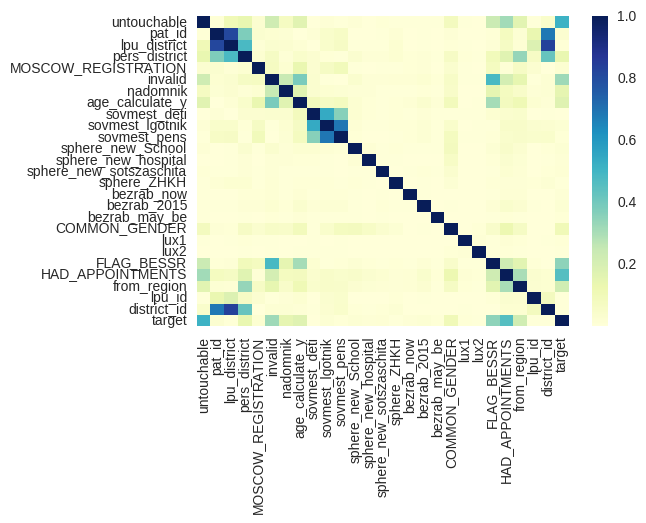

In [20]:
corr = abs(sc_data.corr())
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=False, cmap='YlGnBu')

In [21]:
# Отберём высокоррелированные признаки.
#Порог для выбора высококоррелированных признаков
threshold = 0.5

#Список под хранение пар высококоррелированных признаков
corr_list = []

#Поиск высококорелированных признаков
for i in range(0,len(corr.columns)): 
    for j in range(i+1,len(corr.columns)): 
        if (corr.iloc[i,j] >= threshold and corr.iloc[i,j] < 1) or (corr.iloc[i,j] < 0 and corr.iloc[i,j] <= -threshold):
            corr_list.append([corr.iloc[i,j],i,j])

#Сортировка в порядке убывания коэффициентов корреляции            
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (corr.columns[i],corr.columns[j],v))

lpu_district and district_id = 0.83
pat_id and lpu_district = 0.82
sovmest_lgotnik and sovmest_pens = 0.69
pat_id and district_id = 0.68
sovmest_deti and sovmest_lgotnik = 0.54
untouchable and target = 0.51


### Приблизительно 100 000 тысяч пациентов не имеют московской прописки.

[ 1.  0.]


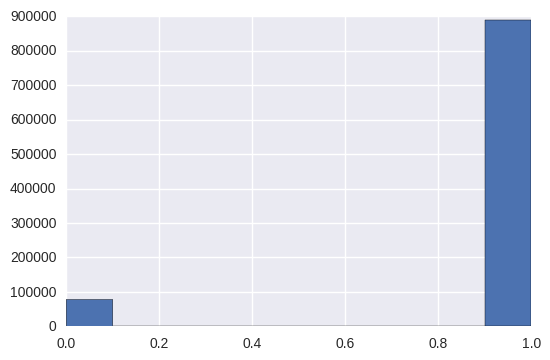

In [22]:
print(sc_data['MOSCOW_REGISTRATION'].unique())
sc_data['MOSCOW_REGISTRATION'].hist()

## Больше половины людей не появлялись в поликлинике за 2 последних года. 

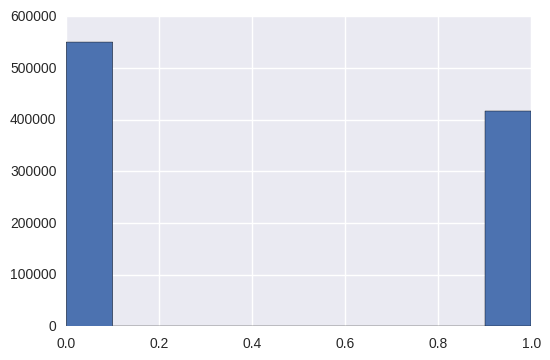

In [23]:
sc_data['HAD_APPOINTMENTS'].hist()

11.824823356401069


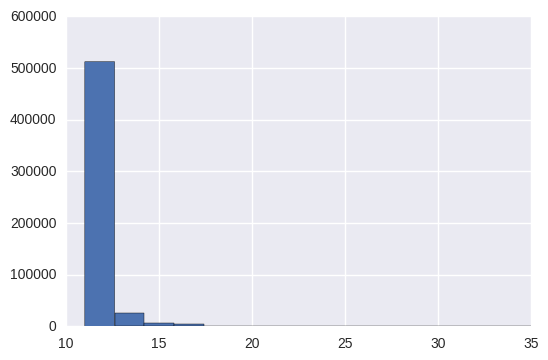

In [24]:
#Хоть они за 2 года ни разу не появлялись, но при этом у них у всех в среднем 12 приемов
print(sc_data.ix[sc_data['HAD_APPOINTMENTS'] == 0,'target'].mean())
sc_data.ix[sc_data['HAD_APPOINTMENTS']==0,'target'].hist(bins=15)

14.905119625831984


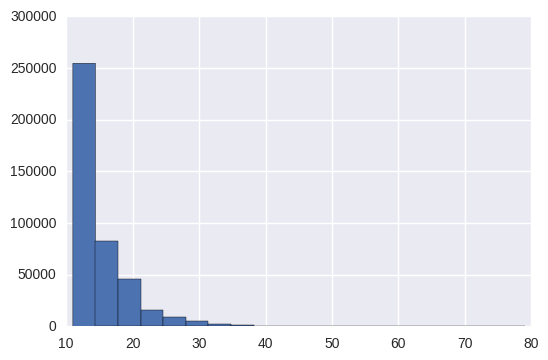

In [25]:
#Люди, которые посещали за 2 года хотя бы раз, тоже в среднем имеют столько же посещений
print(sc_data.ix[sc_data['HAD_APPOINTMENTS']==1,'target'].mean())
sc_data.ix[sc_data['HAD_APPOINTMENTS']==1,'target'].hist(bins=20)

47.4649321328658


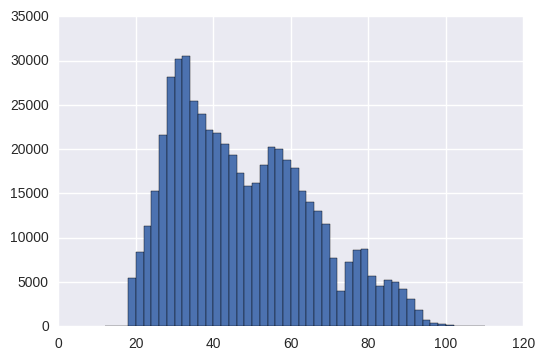

In [26]:
#Средний возраст пациента, который за 2 года ни разу не посетил поликлинику
print(sc_data.ix[sc_data['HAD_APPOINTMENTS']==0,'age_calculate_y'].mean())
#Распределение числа пациентов, которые за 2 года ни разу не посетили поликлинику, по их возрасту
sc_data.ix[sc_data['HAD_APPOINTMENTS']==0,'age_calculate_y'].hist(bins=50,range=[10, 110])

50.63218804341308


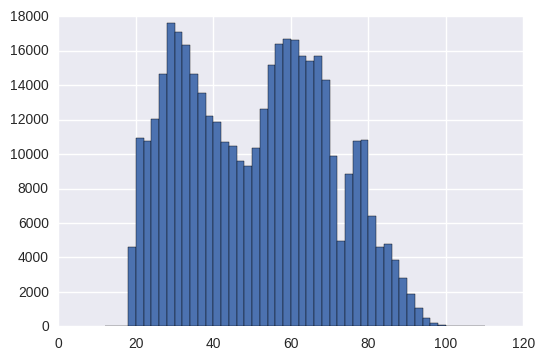

In [27]:
#Средний возраст пациента, который посещал за 2 года хотя бы раз поликлинику
print(sc_data.ix[sc_data['HAD_APPOINTMENTS']==1,'age_calculate_y'].mean())
#Распределение числа пациентов, которые за 2 года хотя бы раз посетили поликлинику, по их возрасту
sc_data.ix[sc_data['HAD_APPOINTMENTS']==1,'age_calculate_y'].hist(bins=50,range=[10, 110])

In [28]:
#очень мало вип персон
np.sum(sc_data['lux1']==1) + np.sum(sc_data['lux2']==1)

1403

In [29]:
sc_data.groupby('lux1').mean()

,untouchable,pat_id,lpu_district,pers_district,MOSCOW_REGISTRATION,invalid,nadomnik,age_calculate_y,sovmest_deti,sovmest_lgotnik,...,bezrab_2015,bezrab_may_be,COMMON_GENDER,lux2,FLAG_BESSR,HAD_APPOINTMENTS,from_region,lpu_id,district_id,target
lux1,,,,,,,,,,,,,,,,,,,,,
0,0.068846,483380.759449,16.982433,31.707282,0.919594,0.116194,0.01061,48.830427,0.634278,1.242329,...,0.009789,0.001446,0.427025,0.000376,0.120714,0.431387,0.306964,12.214772,223.010793,13.153999
1,0.000000,507892.625243,19.439806,39.398058,0.973786,0.039806,0.00000,48.844660,0.907767,1.435922,...,0.002913,0.000971,0.451456,0.009709,0.045631,0.193204,0.436893,11.836893,246.390291,12.067961


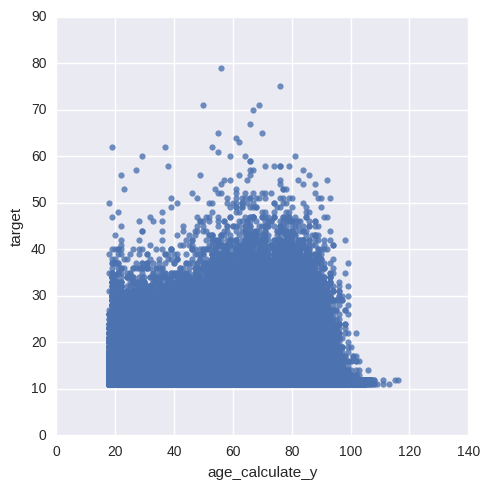

In [30]:
sns.lmplot(x='age_calculate_y', y='target', data=sc_data.ix[sc_data['age_calculate_y']<150,:], palette='Blues',fit_reg=False)
#sns.scatter(sc_data['age_calculate_y'],sc_data['target'])

8


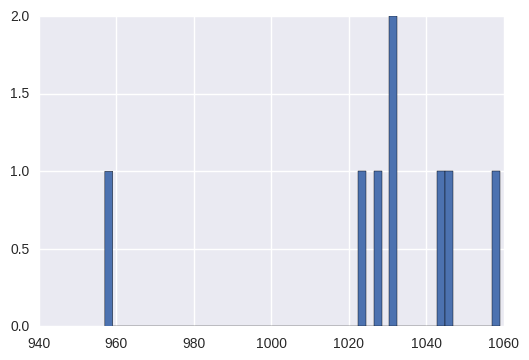

In [31]:
#Количество пациентов, возраст которых больше 950 лет))
print( sc_data.ix[sc_data['age_calculate_y']>950,'age_calculate_y'].count())
sc_data.ix[sc_data['age_calculate_y']>950,'age_calculate_y'].hist(bins=50)

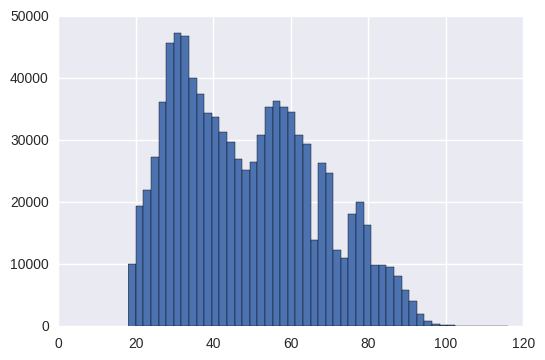

In [32]:
# Распределение количества людей по их возрасту
sc_data.ix[sc_data['age_calculate_y']<150,'age_calculate_y'].hist(bins=50)

In [33]:
#Уникальные значения количества совместно проживающих детей до 14 лет
print(sc_data['sovmest_deti'].unique())

[  0   1   2   3   4   6   5   7   8  11  15  23  10  12  14   9  89  13
  29  49  16  24  28  19  62  20  26  30  18  58  27  32  34  17  31  25
  33  43  22  44  37  99 134  21]


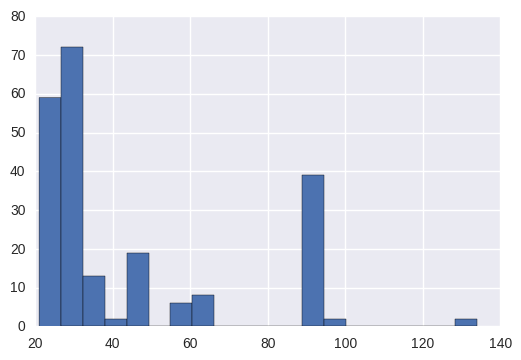

In [34]:
#Распределение числа пациентов, у которых количество детей до 14 лет больше 20
sc_data.ix[sc_data['sovmest_deti']>2*10.0,'sovmest_deti'].hist(bins=20)

In [35]:
#Число пациентов, у которых число совместно проживающих детей больше 20
len(sc_data.ix[sc_data['sovmest_deti']>20,'sovmest_deti'])

222

In [36]:
#Уникальные значения количества совместно льготников
print(sc_data['sovmest_lgotnik'].unique())

[  0   1   3   2   4   5   9   7   6   8  10  21  20  32  14  13 121  16
  17  15  12  34  19  11  30  18  26  37  33  24  35 120  29  45  23  58
  90  51  47  39  25 192  54  31  22  64  63  44  50  57 102  62  42  46
  85  27  28  36 119  65 414  55  48  89 101]


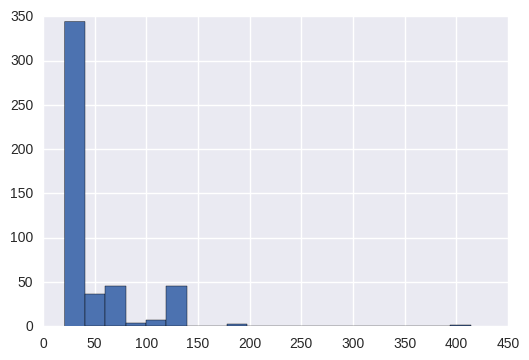

In [37]:
#Распределение числа пациентов, у которых количество совместно проживающих с ними льготников больше 20
sc_data.ix[sc_data['sovmest_lgotnik']>20,'sovmest_lgotnik'].hist(bins=20)

In [38]:
#Число пациентов, которые  совместно проживают с более 50 льготниками
len(sc_data.ix[sc_data['sovmest_lgotnik']>49,'sovmest_lgotnik'])

123

In [39]:
print(sc_data['sovmest_pens'].unique())


[ 0  1  2  3  4  5  7  6 11 17  9 13 48 15 14  8 12 10 27 18 19 47 16 25 23
 55]


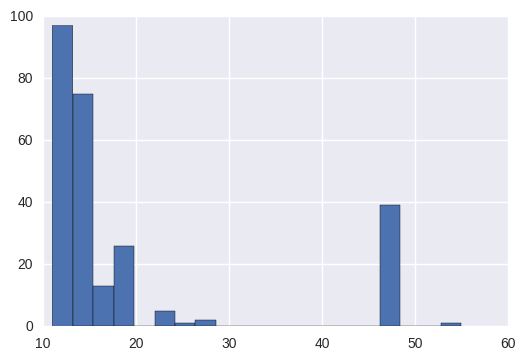

In [40]:
sc_data.ix[sc_data['sovmest_pens']>10,'sovmest_pens'].hist(bins=20)

# 1 путь замены NaN: NaN = 0

### Очистка данных от мусора

In [41]:
print(sc_data.shape)

X = sc_data.drop_duplicates()
print(X.shape)

X = X[X['age_calculate_y']<150]
print(X.shape)

X = X.drop(ufo_indexes.index, axis=0)
print(X.shape)

y = X['target']
print(y.shape)

X = X.drop(['pat_id','target'], axis=1)
print(X.shape)


X['untouchable'].fillna(0, inplace=True)

X.isnull().values.any()

(967044, 27)
(966943, 27)
(966935, 27)
(966767, 27)
(966767,)
(966767, 25)


False

## Суммарное количество визитов пациентами

In [42]:
SUM_target = y.sum()
print(SUM_target)

12715768.0


# Как меняется с возрастом вероятность визита к врачу?

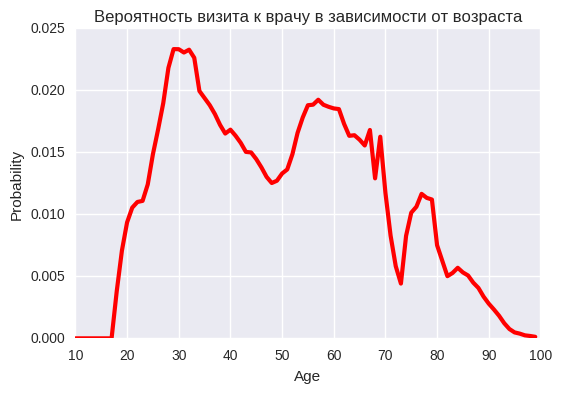

In [43]:
ages=[]
probabilities=[]
for i in range(10,100):
    Xy=pd.concat([X,y],1)
    ages+=[i]
    probabilities+=[(Xy['target'][Xy['age_calculate_y']==i]).sum()/SUM_target]
plt.title('Вероятность визита к врачу в зависимости от возраста')
plt.plot(ages, probabilities,linewidth=3.0,color = 'red')
axes = plt.gca()
plt.xlabel('Age')
plt.ylabel('Probability')
plt.show()

In [44]:
def mae(true,predict):
    return mean_absolute_error(true,predict)

def mse(true,predict):
    return mean_squared_error(true,predict)

def cross_validation(estimator,score_func,X,y,N_folds=3):
    score = cross_val_score(estimator, X=X, y=y, scoring=make_scorer(score_func=score_func, greater_is_better=False), 
                             cv=N_folds, verbose=0, pre_dispatch=1)
    return np.mean(score)


## Построение модели.

# GBM.

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape', X_train.shape)
print('Validation shape', X_valid.shape)

GBM_reg = GBMRegressor(
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=10,
    num_threads=2,
    min_data_in_leaf=8,
    metric='l2',
    feature_fraction=0.8,
    feature_fraction_seed=241,
    bagging_fraction=0.8,
    bagging_freq=100,
    bagging_seed=123,
    metric_freq=1,
    early_stopping_round=50,
    verbose = False
)

print('On cross-validation:')
print("MAE:",cross_validation(GBM_reg,mae,X,y))
print("MSE:",cross_validation(GBM_reg,mse,X,y))


Train shape (773413, 25)
Validation shape (193354, 25)
On cross-validation:
MAE: -1.48261678689
MSE: -6.74508041508


In [46]:
# На валидационной выборке
GBM_reg.fit(X_train, y_train)
print("MAE:", mean_absolute_error(y_valid, GBM_reg.predict(X_valid)))
print("MSE:", mean_squared_error(y_valid, GBM_reg.predict(X_valid)))

MAE: 1.45008404946
MSE: 6.35239760465


# Feature importance.

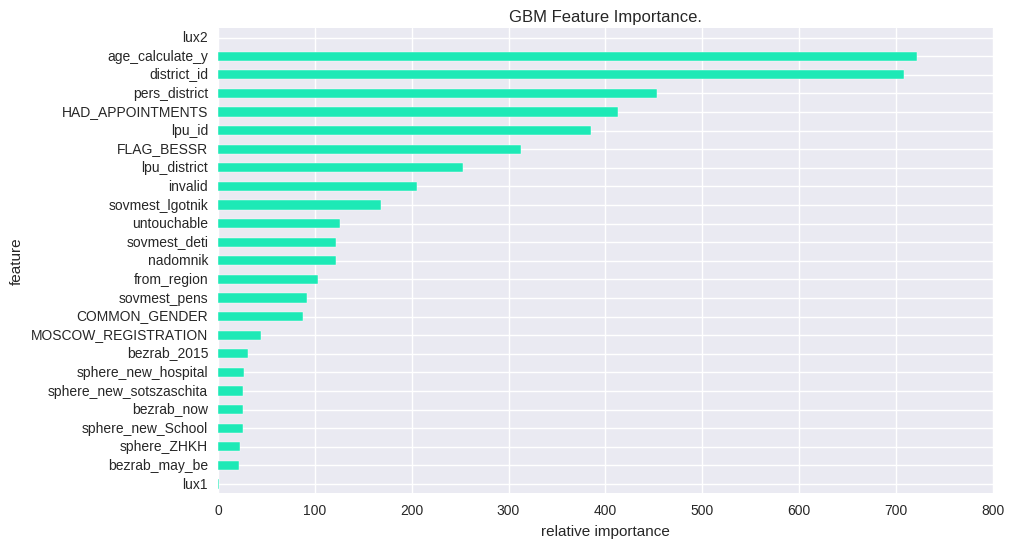

In [47]:
feature_list = X.columns.tolist()
feature_dict = dict(zip(range(len(feature_list)), feature_list))
df_fi = pd.DataFrame({"feature": feature_dict,'importance':GBM_reg.feature_importance()})
df_fi = df_fi.sort_values('importance')
del feature_dict, feature_list


plt.figure()
df_fi.plot(kind='barh',
                     x='feature',
                     y='importance',
                     sort_columns=False,
                     legend=False,
                     figsize=(10, 6),
                     facecolor='#1DE9B6',
                     edgecolor='white')

plt.title('GBM Feature Importance.')
plt.xlabel('relative importance')

# Байессовская оптимизация параметров.

In [48]:
def GBM_reg_eval(learning_rate,num_leaves, min_data_in_leaf, feature_fraction, bagging_fraction,bagging_freq):
    
    GBM_reg = GBMRegressor(
    num_iterations = 500,
    learning_rate=learning_rate,
    num_leaves=int(num_leaves),
    num_threads=2,
    min_data_in_leaf=int(min_data_in_leaf),
    metric='l2',
    feature_fraction=max(feature_fraction,0),
    feature_fraction_seed=241,
    bagging_fraction=max(bagging_fraction,0),
    bagging_freq=int(bagging_freq),
    bagging_seed=123,
    metric_freq=1,
    early_stopping_round=50,
    verbose = False
)
    
    score =  cross_val_score(GBM_reg, X=X, y=y, scoring=make_scorer(score_func=mae, greater_is_better=False), 
                             cv=5, verbose=0, pre_dispatch=1)
    return np.array(score).mean()

In [49]:
%%time
num_iter = 1
init_points = 1

#Параметры, взятые в кавычки оптимизируются
GBM_reg_BO = BayesianOptimization(GBM_reg_eval, 
                              {
                                'learning_rate':(0,1),
                                'num_leaves': (3, 200),
                                'min_data_in_leaf': (2, 200),
                                'feature_fraction': (0.6,1),
                                'bagging_fraction': (0.6,1),
                                'bagging_freq': (1,40),
                              }
                             )

GBM_reg_BO.maximize(init_points=init_points, n_iter=num_iter)



Initialization
----------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   learning_rate |   min_data_in_leaf |   num_leaves | 
    1 | 06m28s |   -1.53167 |             0.6468 |         1.3879 |             0.6653 |          0.3061 |           182.1516 |     138.7631 | 
Bayesian Optimization
----------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   bagging_freq |   feature_fraction |   learning_rate |   min_data_in_leaf |   num_leaves | 
    2 | 04m55s |   -1.61571 |             0.6296 |        34.5939 |             0.8065 |          0.5014 |            48.1775 |     104.7739 | 
CPU times: user 4min 41s, sys: 12.6 s, total: 4min 54s
Wall time: 11min 23s


In [50]:
print('Final Results')

Final Results


In [51]:
#Байессовские параметры
GBM_reg_BO.res['max']['max_params']

{'bagging_fraction': 0.64683720311018356,
 'bagging_freq': 1.3878801981741689,
 'feature_fraction': 0.66532713078017636,
 'learning_rate': 0.30612030323522765,
 'min_data_in_leaf': 182.15158556178176,
 'num_leaves': 138.76311302615065}

In [52]:
print('GBM_MAE_with_bayesian: %f' % GBM_reg_BO.res['max']['max_val'])

GBM_MAE_with_bayesian: -1.531665


### Обучим модель с параметрами, полученными в результате байессовской оптимизации:

In [53]:
GBMRegressor(
    num_iterations = 500,
    learning_rate=0.47506850012560686,
    num_leaves=int(7.8505127010759317),
    num_threads=2,
    min_data_in_leaf=int(15.415882062245869),
    metric='l2',
    feature_fraction=0.62951457164881808,
    feature_fraction_seed=241,
    bagging_fraction=0.85753260727375658,
    bagging_freq=int(26.103250555246248),
    bagging_seed=123,
    metric_freq=1,
    early_stopping_round=50,
    verbose = False
).fit(X,y)

print("MAE:", mean_absolute_error(y_valid, GBM_reg.predict(X_valid)))
print("MSE:", mean_squared_error(y_valid, GBM_reg.predict(X_valid)))

MAE: 1.45008404946
MSE: 6.35239760465


## Далее NaN в untouchable заменялся на 1 и 2, но это никак не повлияло на MAE для прогноза количества визитов, поэтому для определения кол-ва визитов этот признак особой роли не играет.

## XGBoost. 

In [57]:
%%time
XGB =xgb.XGBRegressor(max_depth=3, 
                      learning_rate=0.2, 
                      n_estimators=50,
                      silent=True,
                      objective='reg:linear',
                      nthread=2,
                      gamma=0,
                      min_child_weight=1,
                     max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5, 
                      seed=1,
                      missing=None)

print('On cross-validation:')
print("MAE:",cross_validation(XGB,mae,X,y))
print("MAE:",cross_validation(XGB,mse,X,y))

On cross-validation:
MAE: -1.50737112992
MAE: -6.8777724627
CPU times: user 3min 22s, sys: 1.02 s, total: 3min 23s
Wall time: 1min 45s


# Stacking.

In [58]:
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from sklearn.linear_model import LinearRegression

In [59]:
# create dataset
dataset = Dataset(X_train,y_train,X_valid)

# initialize GBM & XGB
model_GBM = Regressor(dataset=dataset, estimator=GBMRegressor,parameters={
    'num_iterations': 500,
    'learning_rate':0.47506850012560686,
    'num_leaves':int(7.8505127010759317),
    'num_threads':2,
    'min_data_in_leaf':int(15.415882062245869),
    'metric':'l2',
    'feature_fraction':0.62951457164881808,
    'feature_fraction_seed':241,
    'bagging_fraction':0.85753260727375658,
    'bagging_freq':int(26.103250555246248),
    'bagging_seed':123,
    'metric_freq':1,
    'early_stopping_round':50,
    'verbose': False},
    name ="GBM")

model_XGB = Regressor(dataset=dataset, estimator=xgb.XGBRegressor,
        parameters={
        'max_depth':3, 
        'learning_rate':0.2, 
        'n_estimators':50,
        'silent':True,
        'objective':'reg:linear',
        'nthread':2,
        'gamma':0,
        'min_child_weight':1,
        'max_delta_step':0,
        'subsample':1,
        'colsample_bytree':1,
        'colsample_bylevel':1,
        'reg_alpha':0,
        'reg_lambda':1,
        'scale_pos_weight':1,
        'base_score':0.5, 
        'seed':1,
        'missing':None},
        name='XGB')

# Stack two models
# Returns new dataset with out-of-fold predictions
pipeline = ModelsPipeline(model_GBM,model_XGB)
stack_ds = pipeline.stack(k=3,seed=111)

In [60]:
# Train GBM on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=GBMRegressor,parameters={
    'num_iterations': 500,
    'learning_rate':0.47506850012560686,
    'num_leaves':int(7.8505127010759317),
    'num_threads':2,
    'min_data_in_leaf':int(15.415882062245869),
    'metric':'l2',
    'feature_fraction':0.62951457164881808,
    'feature_fraction_seed':241,
    'bagging_fraction':0.85753260727375658,
    'bagging_freq':int(26.103250555246248),
    'bagging_seed':123,
    'metric_freq':1,
    'early_stopping_round':50,
    'verbose': False})
results = stacker.predict()

In [61]:
#MAE между X_valid и stacker.predict()
mae(results, y_valid)

1.4445184061358958

In [62]:
# Validate results using 3 fold cross-validation
results_on_cv = stacker.validate(k=3,scorer=mae)

Metric: mae
Folds accuracy: [1.4527801586470392, 1.4588245799134225, 1.4579178368062558]
Mean accuracy: 1.45650752512
Standard Deviation: 0.00266151478121
Variance: 7.08366093062e-06


In [63]:
def stacker_eval_for_BO(learning_rate,num_leaves, feature_fraction, bagging_fraction):
    
    stacker = Regressor(dataset=stack_ds, estimator=GBMRegressor,parameters={
    'num_iterations': 500,
    'learning_rate':learning_rate,
    'num_leaves':int(num_leaves),
    'num_threads':2,
    'min_data_in_leaf':int(15.415882062245869),
    'metric':'l2',
    'feature_fraction':feature_fraction,
    'feature_fraction_seed':241,
    'bagging_fraction':bagging_fraction,
    'bagging_freq':int(26.103250555246248),
    'bagging_seed':123,
    'metric_freq':1,
    'early_stopping_round':50,
    'verbose': False})
    results = stacker.predict()
    return mae(results, y_valid)

In [64]:
%%time
num_iter = 1
init_points = 1

#Параметры, взятые в кавычки оптимизируются
stacker_BO = BayesianOptimization(stacker_eval_for_BO, 
                              {
                                'learning_rate':(0.1,1),
                                'num_leaves': (3, 50),
                                'feature_fraction': (0.6,1),
                                'bagging_fraction': (0.6,1),
                              }
                             )

stacker_BO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
--------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   learning_rate |   num_leaves | 
    1 | 00m31s |    1.44649 |             0.7678 |             0.7115 |          0.1041 |      47.2651 | 
Bayesian Optimization
--------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   learning_rate |   num_leaves | 
    2 | 00m39s |    1.44480 |             0.6978 |             0.7173 |          0.4801 |      48.1764 | 
CPU times: user 30.9 s, sys: 368 ms, total: 31.3 s
Wall time: 1min 10s


In [65]:
#Байессовские параметры
stacker_BO.res['max']['max_params']

{'bagging_fraction': 0.76777032269985912,
 'feature_fraction': 0.71149836303941871,
 'learning_rate': 0.10414791739742632,
 'num_leaves': 47.265135299346881}

In [66]:
print('Stacker_MAE_with_bayesian: %f' % stacker_BO.res['max']['max_val'])

Stacker_MAE_with_bayesian: 1.446492


### Качество стэкера значительно не улучшилось, даже, когда брались num_iter = 40, init_points. 






# Возникает вопрос:
# Балансировка участков = задача кластеризации ???

# Балансировка участков на скоринговой модели на 3 поликлиниках c LPU_ID равными 13, 17 или 19.

## Расммотрим LPU_ID = 13.

In [67]:
#Сформируем и очистим данные для LPU_ID = 13
X_lpu_13 = sc_data.drop_duplicates()

X_lpu_13 = X_lpu_13[X_lpu_13['age_calculate_y']<150]

X_lpu_13 = X_lpu_13.drop(ufo_indexes.index, axis=0)


#Операция присваивания не копирует объект, она лишь создаёт ссылку на объект. А она нам нужна именно копия!
X_train_13 = deepcopy(X_lpu_13)
X_lpu_13 = X_lpu_13[X_lpu_13['lpu_id']==13]
print(X_lpu_13.shape)
print(X_train_13.shape)

y_lpu_13 = X_lpu_13['target']
y_train_13 = X_train_13['target'] 
print(y_lpu_13.shape)
print(y_train_13.shape)

X_lpu_13 = X_lpu_13.drop(['target'], axis=1)
X_train_13 = X_train_13.drop(['target'], axis=1)
print(X_lpu_13.shape)
print(X_train_13.shape)


X_train_13['untouchable'].fillna(0, inplace=True) #допущение-эвристика
X_lpu_13['untouchable'].fillna(0, inplace=True) #допущение-эвристика

(78572, 27)
(966767, 27)
(78572,)
(966767,)
(78572, 26)
(966767, 26)


### Будем пользоваться только GBM'омом для прогноза target, поскольку разница м/у ним и результатом stacking'а не велика 

In [68]:
GBM_reg=GBMRegressor(
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=10,
    num_threads=-1,
    min_data_in_leaf=8,
    metric='l2',
    feature_fraction=0.8,
    feature_fraction_seed=241,
    bagging_fraction=0.8,
    bagging_freq=100,
    bagging_seed=123,
    metric_freq=1,
    early_stopping_round=50,
    verbose = False)

GBM_reg.fit(X_train_13.drop(['pat_id'],axis=1), y_train_13)

#Сделаем прогноз для target и округлим его до целых чисел
HAT_y_lpu_13 = np.round(GBM_reg.predict(X_lpu_13.drop(['pat_id'],axis=1))) 

In [69]:
MAE = mae(y_lpu_13,HAT_y_lpu_13) #погрешность для одного target'а - eps

In [70]:
MAE

1.1387008094486586

### Не забудь учесть в балансировке "неприкасаемых" !!!

In [71]:
X_lpu_13['target'] = HAT_y_lpu_13
X_lpu_13.shape

(78572, 27)

In [72]:
X_lpu_13.columns

Index(['untouchable', 'pat_id', 'lpu_district', 'pers_district',
       'MOSCOW_REGISTRATION', 'invalid', 'nadomnik', 'age_calculate_y',
       'sovmest_deti', 'sovmest_lgotnik', 'sovmest_pens', 'sphere_new_School',
       'sphere_new_hospital', 'sphere_new_sotszaschita', 'sphere_ZHKH',
       'bezrab_now', 'bezrab_2015', 'bezrab_may_be', 'COMMON_GENDER', 'lux1',
       'lux2', 'FLAG_BESSR', 'HAD_APPOINTMENTS', 'from_region', 'lpu_id',
       'district_id', 'target'],
      dtype='object')

In [73]:
lpu_13 = deepcopy(X_lpu_13)
#Уберём из lpu_13 все столбцы, кроме pat_id, district_id,target, untouchable
for col in X_lpu_13.columns:
    if(col != 'pat_id' and col != 'district_id' and col != 'target' and col != 'untouchable'):
        lpu_13 = lpu_13.drop([col], axis=1)

In [74]:
lpu_13.head()

,untouchable,pat_id,district_id,target
10687,0.0,4122,129,12.0
10688,0.0,4434,280,12.0
10689,0.0,5952,84,12.0
10690,0.0,6292,129,12.0
10691,0.0,6405,247,12.0


In [75]:
len(lpu_13)

78572

## Число уникальных участков по рассматриваемой поликлиники

In [76]:
lpu_13['district_id'].nunique()

35

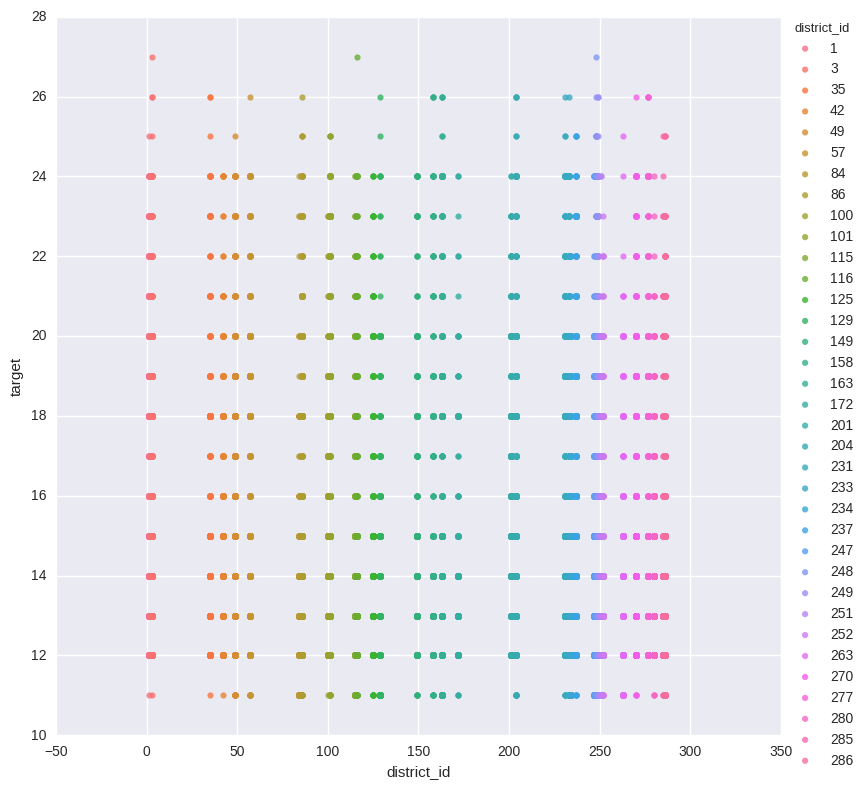

In [77]:
sns.lmplot(x='district_id',y='target', hue='district_id', data=lpu_13, size=8,fit_reg=False)

# Да уж, из такого графика не сбалансируешь :))

In [78]:
#Cписок под хранение уникального значения district_id
district_id_lpu_13=[]
#Cписок под хранение cуммарного target по данному district_id
sum_target_lpu_13 = []
sum_target_by_district_id_LPU_13 = pd.DataFrame()
for district_id in lpu_13['district_id'].unique():
    district_id_lpu_13+=[district_id]
    sum_target_lpu_13+=[sum(lpu_13['target'][lpu_13['district_id']==district_id])]

sum_target_by_district_id_LPU_13['district_id']=district_id_lpu_13
sum_target_by_district_id_LPU_13['sum_target']=sum_target_lpu_13

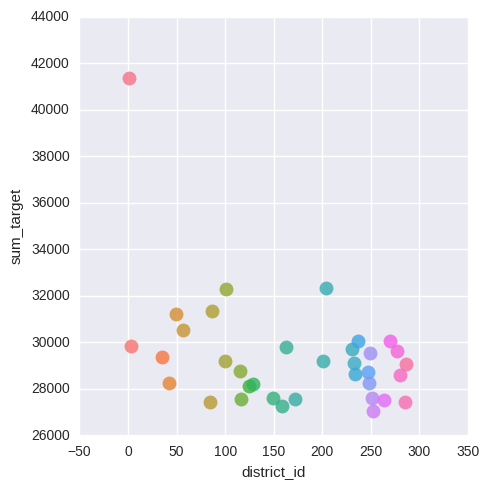

In [79]:
sns.lmplot(x='district_id',y='sum_target', hue='district_id', data=sum_target_by_district_id_LPU_13, legend=False, fit_reg=False,scatter_kws={"s": 100})

# Наш цель -- сделать одинаковой нагрузку на всех участках внутри поликлиники, поэтому точки на приведённом выше графики в идеале должны лежать на одной и той же горизонтальной прямой.

# Целевое=балансное значение для каждого участка  поликлиники:
# Cумма всех предсказанных визитов по данной поликлиники, поделённая на количество участков.


In [80]:
#целевое значение для lpu_id = 13
goal_lpu_13 = sum(lpu_13['target'])/lpu_13['district_id'].nunique()
print(goal_lpu_13)

29376.1428571


In [81]:
#Погрешность целевого значения для lpu_id = 13
precision_goal_lpu_13 = MAE*len(lpu_13)/lpu_13['district_id'].nunique()
print(precision_goal_lpu_13)

2556.28571429


# Погрешность c учётом построеной модели предсказания target составляет 8.7%.

In [82]:
#Данные для формирования полосы, в которой должны лежать все суммарные таргеты по каждому участку
lower_bound = pd.DataFrame()
lower_bound['district_id'] = lpu_13['district_id']
lower_bound['goal_lpu_13'] = goal_lpu_13 - 1500#precision_goal_lpu_13

upper_bound = pd.DataFrame()
upper_bound['district_id'] = lpu_13['district_id']
upper_bound['goal_lpu_13'] = goal_lpu_13 + 1500#precision_goal_lpu_13

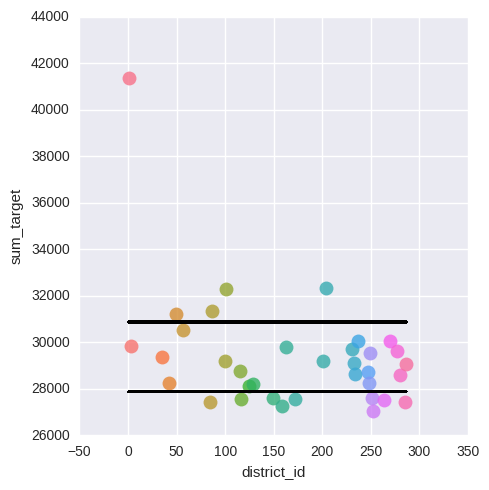

In [83]:
sns.lmplot(x='district_id',y='sum_target', hue='district_id', data=sum_target_by_district_id_LPU_13, legend=False, fit_reg=False,scatter_kws={"s": 100})
plt.plot(lower_bound['district_id'], lower_bound['goal_lpu_13'],color = 'black')
plt.plot(upper_bound['district_id'], upper_bound['goal_lpu_13'],color = 'black')


# Далее, к этому целевому значению будем подводить каждый участок. 

# Попробую кластеризацию.

# k-means

In [84]:
from sklearn.cluster import KMeans

In [85]:
kmeans_13 = KMeans(n_clusters=35,max_iter=500,random_state=245, n_init=100,n_jobs=-1)
kmeans_13.fit(lpu_13.drop(['pat_id','district_id'],1).values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=35, n_init=100, n_jobs=-1, precompute_distances='auto',
    random_state=245, tol=0.0001, verbose=0)

In [86]:
kmeans_13.labels_

array([0, 0, 0, ..., 6, 0, 0], dtype=int32)

In [87]:
lpu_13['kmeans_label']=kmeans_13.labels_

In [88]:
#Cписок под хранение меток k-means
kmeans_labels_lpu_13=[]
#Cписок под хранение cуммарного target по данной метке
kmeans_sum_target_lpu_13 = []

kmeans_sum_target_by_klabel_LPU_13 = pd.DataFrame()

for kmeans_label in lpu_13['kmeans_label'].unique():
    kmeans_labels_lpu_13+=[kmeans_label]
    kmeans_sum_target_lpu_13+=[sum(lpu_13['target'][lpu_13['kmeans_label']==kmeans_label])]

kmeans_sum_target_by_klabel_LPU_13['kmeans_label']=kmeans_labels_lpu_13
kmeans_sum_target_by_klabel_LPU_13['sum_target']=kmeans_sum_target_lpu_13

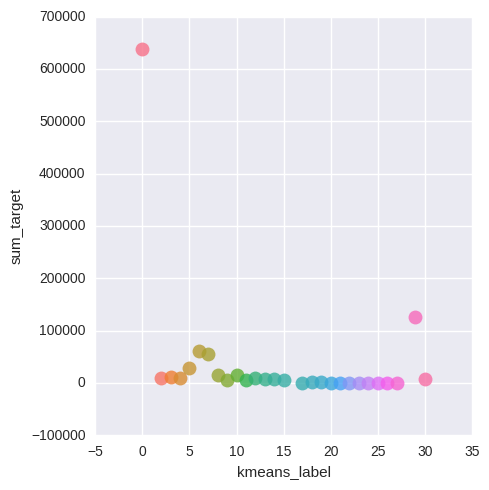

In [89]:
sns.lmplot(x='kmeans_label',y='sum_target', hue='kmeans_label', data=kmeans_sum_target_by_klabel_LPU_13, legend=False, fit_reg=False,scatter_kws={"s": 100})

# Пробовал разные параметры в k-means  с надеждой на то, что он сможет так отобрать данные в кластеры, что на приведённом выше графики наблюдалось бы что-то похожее на равновесную горизнатальную прямую. 

In [90]:
lpu_13 = lpu_13.drop(['kmeans_label'],1)

# Буду делать всё вручную.

## Отсортируем LPU_ID=13 по target. (Сортировку не надо делать для самой балансировки)

In [91]:
#было
lpu_13.head(5)

,untouchable,pat_id,district_id,target
10687,0.0,4122,129,12.0
10688,0.0,4434,280,12.0
10689,0.0,5952,84,12.0
10690,0.0,6292,129,12.0
10691,0.0,6405,247,12.0


In [92]:
lpu_13.sort(columns='target',axis=0, ascending=False,inplace=True) #cортируем на месте

In [93]:
#стало
lpu_13.head(5)

,untouchable,pat_id,district_id,target
496523,1.0,397443,116,27.0
689111,1.0,346430,248,27.0
658973,1.0,427787,3,27.0
480242,1.0,171753,204,26.0
687751,1.0,97934,163,26.0


In [94]:
# Словарь, содержащий суммарные нагрузки по участкам 
loading = dict()
for district_id in lpu_13['district_id'].unique():
    loading[district_id]=sum(lpu_13['target'][lpu_13['district_id']==district_id])

In [95]:
loading

{1: 41354.0,
 3: 29831.0,
 35: 29382.0,
 42: 28231.0,
 49: 31234.0,
 57: 30513.0,
 84: 27423.0,
 86: 31347.0,
 100: 29205.0,
 101: 32284.0,
 115: 28764.0,
 116: 27583.0,
 125: 28116.0,
 129: 28208.0,
 149: 27585.0,
 158: 27243.0,
 163: 29801.0,
 172: 27552.0,
 201: 29181.0,
 204: 32353.0,
 231: 29722.0,
 233: 29122.0,
 234: 28654.0,
 237: 30073.0,
 247: 28718.0,
 248: 28265.0,
 249: 29526.0,
 251: 27599.0,
 252: 27031.0,
 263: 27526.0,
 270: 30040.0,
 277: 29611.0,
 280: 28598.0,
 285: 27440.0,
 286: 29050.0}

In [96]:
print('Участок с минимальной загрузкой:')
print('district_id =',min(loading, key=loading.get),'нагрузка:',loading[min(loading, key=loading.get)])

Участок с минимальной загрузкой:
district_id = 252 нагрузка: 27031.0


In [97]:
print('Участок с максимальной загрузкой:')
print('district_id =',max(loading, key=loading.get),'нагрузка:',loading[max(loading, key=loading.get)])

Участок с максимальной загрузкой:
district_id = 1 нагрузка: 41354.0


In [98]:
len(lpu_13[lpu_13['district_id']==1])

2951

In [99]:
len(lpu_13[lpu_13['district_id']==101])

2226

# В цикле будем проводить последовательно балансировку м/у макс и мин по нагруженности участкам

In [100]:
%%time

#счётчик подсчёта перемещённых людей
counter_of_moving_people=0

#использую флаги состояний, говорящие о достижении равновесия
flags = pd.DataFrame({'district_id':lpu_13['district_id'].unique(),'balance?':np.zeros(lpu_13['district_id'].nunique())})

for mm in range(10000):                   #до этого было -- while True:, но так мы застраховываемся от зацикливания 
    #Участок с минимальной загрузкой
    key_min = min(loading, key=loading.get)
    MIN = loading[key_min]
    
    #Участок с максимальной загрузкой
    key_max = max(loading, key=loading.get)
    MAX = loading[key_max]
    
    #балансировка: переносим пациента с наибольшим target с участка максимальной загруженности
    #на участок c минимальной загруженностью 
    #на другой, пока не достигнем равновесия. Не прикасаемых не трогаем
    targets_with_key_max = lpu_13['target'][lpu_13['district_id'] == key_max]
    index_max_target = targets_with_key_max.idxmax()
    
    lpu_13.loc[index_max_target,'district_id'] = key_min
    counter_of_moving_people +=1
   
    #условие выхода из цикла: порог на количество перемещённых людей
    if counter_of_moving_people > 0.25*len(lpu_13):
        break
    
    #использую флаги состояний, говорящие о достижении равновесия
    for district_id in lpu_13['district_id'].unique():   
        #если суммарный target по данному участку находится в пределах погрешности балансного, целевого значения,то
        #флаг баланса по данному участку выставляем равным 1
        if abs(sum(lpu_13['target'][lpu_13['district_id'] == district_id]) - goal_lpu_13) < 1500:
            flags['balance?'][flags['district_id'] == district_id] = 1
    
    #условие выхода из цикла: все флаги равны 1, то есть все участки сбалансированы с заданной точностью
    if flags['balance?'].all():
        break
    
    flags['balance?'] = 0
    
    #Обновить словарь
    loading = dict()
    for district_id in lpu_13['district_id'].unique():
        loading[district_id]=sum(lpu_13['target'][lpu_13['district_id']==district_id])

CPU times: user 2min 4s, sys: 60 ms, total: 2min 4s
Wall time: 2min 4s


In [101]:
# Число перемещённых людей
counter_of_moving_people

721

# Визуализация результатов балансировки по LPU_ID=13

In [102]:
#Cписок под хранение уникального значения district_id
district_id_lpu_13=[]
#Cписок под хранение cуммарного target по данному district_id после балансировки
sum_target_lpu_13 = []
sum_target_by_district_id_LPU_13 = pd.DataFrame()
for district_id in lpu_13['district_id'].unique():
    district_id_lpu_13+=[district_id]
    sum_target_lpu_13+=[sum(lpu_13['target'][lpu_13['district_id']==district_id])]

sum_target_by_district_id_LPU_13['district_id']=district_id_lpu_13
sum_target_by_district_id_LPU_13['sum_target']=sum_target_lpu_13

In [103]:
#Данные для формирования полосы, в которой должны лежать все суммарные таргеты по каждому участку
lower_bound = pd.DataFrame()
lower_bound['district_id'] = lpu_13['district_id']
lower_bound['goal_lpu_13'] = goal_lpu_13 - 1500

upper_bound = pd.DataFrame()
upper_bound['district_id'] = lpu_13['district_id']
upper_bound['goal_lpu_13'] = goal_lpu_13 + 1500

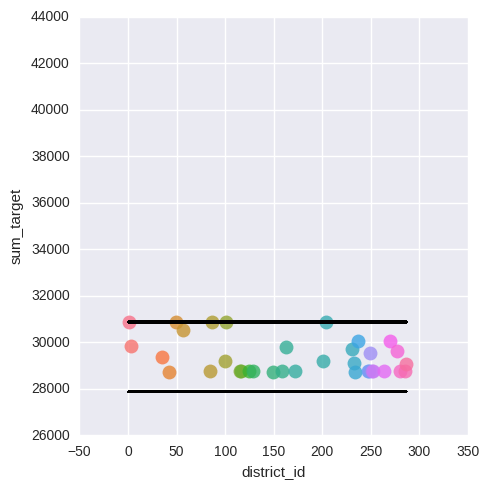

In [104]:
lm=sns.lmplot(x='district_id',y='sum_target', hue='district_id',scatter_kws={"s": 100}, data=sum_target_by_district_id_LPU_13, legend=False, fit_reg=False)
lm.axes[0,0].set_ylim(26000,44000)
plt.plot(lower_bound['district_id'], lower_bound['goal_lpu_13'],color = 'black')
plt.plot(upper_bound['district_id'], upper_bound['goal_lpu_13'],color = 'black')

# Чёрные линии -- это границы погрешности.

# Для всех остальных поликлиник процесс балансировки проводится ПОЛНОСТЬЮ аналогично.


## Расммотрим LPU_ID = 17.

In [105]:
#Сформируем и очистим данные для LPU_ID = 17
X_lpu_17 = sc_data.drop_duplicates()

X_lpu_17 = X_lpu_17[X_lpu_17['age_calculate_y']<150]

X_lpu_17 = X_lpu_17.drop(ufo_indexes.index, axis=0)


#Операция присваивания не копирует объект, она лишь создаёт ссылку на объект. А она нам нужна именно копия!
X_train_17 = deepcopy(X_lpu_17)
X_lpu_17 = X_lpu_17[X_lpu_17['lpu_id']==17]
print(X_lpu_17.shape)
print(X_train_17.shape)

y_lpu_17 = X_lpu_17['target']
y_train_17 = X_train_17['target'] 
print(y_lpu_17.shape)
print(y_train_17.shape)

X_lpu_17 = X_lpu_17.drop(['target'], axis=1)
X_train_17 = X_train_17.drop(['target'], axis=1)
print(X_lpu_17.shape)
print(X_train_17.shape)


X_train_17['untouchable'].fillna(0, inplace=True) #допущение-эвристика
X_lpu_17['untouchable'].fillna(0, inplace=True) #допущение-эвристика

(58999, 27)
(966767, 27)
(58999,)
(966767,)
(58999, 26)
(966767, 26)


In [106]:
GBM_reg=GBMRegressor(
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=10,
    num_threads=-1,
    min_data_in_leaf=8,
    metric='l2',
    feature_fraction=0.8,
    feature_fraction_seed=241,
    bagging_fraction=0.8,
    bagging_freq=100,
    bagging_seed=123,
    metric_freq=1,
    early_stopping_round=50,
    verbose = False)

GBM_reg.fit(X_train_17.drop(['pat_id'],axis=1), y_train_17)

#Сделаем прогноз для target и округлим его до целых чисел
HAT_y_lpu_17 = np.round(GBM_reg.predict(X_lpu_17.drop(['pat_id'],axis=1))) 

In [107]:
MAE = mae(y_lpu_17,HAT_y_lpu_17) #погрешность для одного target'а - eps

In [108]:
MAE

1.688265902811912

In [109]:
X_lpu_17['target'] = HAT_y_lpu_17
X_lpu_17.shape

(58999, 27)

In [110]:
lpu_17 = deepcopy(X_lpu_17)
#Уберём из lpu_17 все столбцы, кроме pat_id, district_id,target, untouchable
for col in X_lpu_17.columns:
    if(col != 'pat_id' and col != 'district_id' and col != 'target' and col != 'untouchable'):
        lpu_17 = lpu_17.drop([col], axis=1)

In [111]:
#Cписок под хранение уникального значения district_id
district_id_lpu_17=[]
#Cписок под хранение cуммарного target по данному district_id
sum_target_lpu_17 = []
sum_target_by_district_id_LPU_17 = pd.DataFrame()
for district_id in lpu_17['district_id'].unique():
    district_id_lpu_17+=[district_id]
    sum_target_lpu_17+=[sum(lpu_17['target'][lpu_17['district_id']==district_id])]

sum_target_by_district_id_LPU_17['district_id']=district_id_lpu_17
sum_target_by_district_id_LPU_17['sum_target']=sum_target_lpu_17

In [112]:
#целевое значение для lpu_id = 17
goal_lpu_17 = sum(lpu_17['target'])/lpu_17['district_id'].nunique()
print(goal_lpu_17)

31390.1153846


In [113]:
#Погрешность целевого значения для lpu_id = 17
precision_goal_lpu_17 = MAE*len(lpu_17)/lpu_17['district_id'].nunique()
print(precision_goal_lpu_17)

3831.0


In [114]:
#Данные для формирования полосы, в которой должны лежать все суммарные таргеты по каждому участку
lower_bound = pd.DataFrame()
lower_bound['district_id'] = lpu_17['district_id']
lower_bound['goal_lpu_17'] = goal_lpu_17 - 1600#precision_goal_lpu_17

upper_bound = pd.DataFrame()
upper_bound['district_id'] = lpu_17['district_id']
upper_bound['goal_lpu_17'] = goal_lpu_17 + 1600#precision_goal_lpu_17

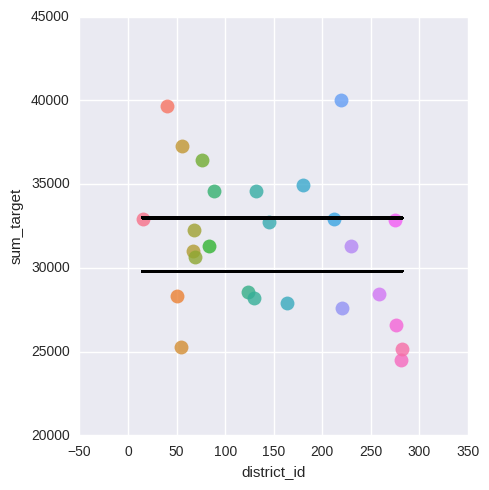

In [115]:
sns.lmplot(x='district_id',y='sum_target', hue='district_id', data=sum_target_by_district_id_LPU_17, legend=False, fit_reg=False,scatter_kws={"s": 100})
plt.plot(lower_bound['district_id'], lower_bound['goal_lpu_17'],color = 'black')
plt.plot(upper_bound['district_id'], upper_bound['goal_lpu_17'],color = 'black')

In [116]:
# Словарь, содержащий суммарные нагрузки по участкам 
loading = dict()
for district_id in lpu_17['district_id'].unique():
    loading[district_id]=sum(lpu_17['target'][lpu_17['district_id']==district_id])

In [117]:
%%time

#счётчик подсчёта перемещённых людей
counter_of_moving_people=0

#использую флаги состояний, говорящие о достижении равновесия
flags = pd.DataFrame({'district_id':lpu_17['district_id'].unique(),'balance?':np.zeros(lpu_17['district_id'].nunique())})

for mm in range(10000):                   #до этого было -- while True:, но так мы застраховываемся от зацикливания 
    #Участок с минимальной загрузкой
    key_min = min(loading, key=loading.get)
    MIN = loading[key_min]
    
    #Участок с максимальной загрузкой
    key_max = max(loading, key=loading.get)
    MAX = loading[key_max]
    
    #балансировка: переносим пациента с наибольшим target с участка максимальной загруженности
    #на участок c минимальной загруженностью 
    #на другой, пока не достигнем равновесия. Не прикасаемых не трогаем
    targets_with_key_max = lpu_17['target'][lpu_17['district_id'] == key_max]
    index_max_target = targets_with_key_max.idxmax()
    
    lpu_17.loc[index_max_target,'district_id'] = key_min
    counter_of_moving_people +=1
   
    #условие выхода из цикла: порог на количество перемещённых людей
    if counter_of_moving_people > 0.25*len(lpu_17):
        break
    
    #использую флаги состояний, говорящие о достижении равновесия
    for district_id in lpu_17['district_id'].unique():   
        #если суммарный target по данному участку находится в пределах погрешности балансного, целевого значения,то
        #флаг баланса по данному участку выставляем равным 1
        if abs(sum(lpu_17['target'][lpu_17['district_id'] == district_id]) - goal_lpu_17) < 1500:
            flags['balance?'][flags['district_id'] == district_id] = 1
    
    #условие выхода из цикла: все флаги равны 1, то есть все участки сбалансированы с заданной точностью
    if flags['balance?'].all():
        break
    
    flags['balance?'] = 0
    
    #Обновить словарь
    loading = dict()
    for district_id in lpu_17['district_id'].unique():
        loading[district_id]=sum(lpu_17['target'][lpu_17['district_id']==district_id])

CPU times: user 1min 56s, sys: 84 ms, total: 1min 56s
Wall time: 1min 56s


In [118]:
counter_of_moving_people

1318

# Визуализация результатов балансировки по LPU_ID=17

In [119]:
#Cписок под хранение уникального значения district_id
district_id_lpu_17=[]
#Cписок под хранение cуммарного target по данному district_id
sum_target_lpu_17 = []
sum_target_by_district_id_LPU_17 = pd.DataFrame()
for district_id in lpu_17['district_id'].unique():
    district_id_lpu_17+=[district_id]
    sum_target_lpu_17+=[sum(lpu_17['target'][lpu_17['district_id']==district_id])]

sum_target_by_district_id_LPU_17['district_id']=district_id_lpu_17
sum_target_by_district_id_LPU_17['sum_target']=sum_target_lpu_17

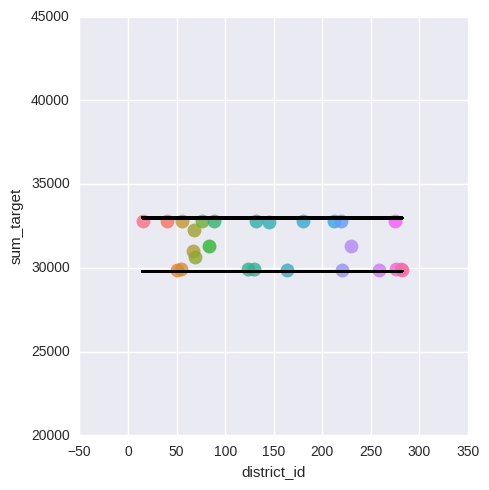

In [120]:
lm=sns.lmplot(x='district_id',y='sum_target', hue='district_id', data=sum_target_by_district_id_LPU_17, legend=False, fit_reg=False,scatter_kws={"s": 100})
lm.axes[0,0].set_ylim(20000,45000)
plt.plot(lower_bound['district_id'], lower_bound['goal_lpu_17'],color = 'black')
plt.plot(upper_bound['district_id'], upper_bound['goal_lpu_17'],color = 'black')

## Расммотрим LPU_ID = 19.

In [121]:
#Сформируем и очистим данные для LPU_ID = 19
X_lpu_19 = sc_data.drop_duplicates()

X_lpu_19 = X_lpu_19[X_lpu_19['age_calculate_y']<150]

X_lpu_19 = X_lpu_19.drop(ufo_indexes.index, axis=0)


#Операция присваивания не копирует объект, она лишь создаёт ссылку на объект. А она нам нужна именно копия!
X_train_19 = deepcopy(X_lpu_19)
X_lpu_19 = X_lpu_19[X_lpu_19['lpu_id']==19]
print(X_lpu_19.shape)
print(X_train_19.shape)

y_lpu_19 = X_lpu_19['target']
y_train_19 = X_train_19['target'] 
print(y_lpu_19.shape)
print(y_train_19.shape)

X_lpu_19 = X_lpu_19.drop(['target'], axis=1)
X_train_19 = X_train_19.drop(['target'], axis=1)
print(X_lpu_19.shape)
print(X_train_19.shape)


X_train_19['untouchable'].fillna(0, inplace=True) #допущение-эвристика
X_lpu_19['untouchable'].fillna(0, inplace=True) #допущение-эвристика

(73366, 27)
(966767, 27)
(73366,)
(966767,)
(73366, 26)
(966767, 26)


In [122]:
GBM_reg=GBMRegressor(
    num_iterations=500,
    learning_rate=0.1,
    num_leaves=10,
    num_threads=-1,
    min_data_in_leaf=8,
    metric='l2',
    feature_fraction=0.8,
    feature_fraction_seed=241,
    bagging_fraction=0.8,
    bagging_freq=100,
    bagging_seed=123,
    metric_freq=1,
    early_stopping_round=50,
    verbose = False)

GBM_reg.fit(X_train_19.drop(['pat_id'],axis=1), y_train_19)

#Сделаем прогноз для target и округлим его до целых чисел
HAT_y_lpu_19 = np.round(GBM_reg.predict(X_lpu_19.drop(['pat_id'],axis=1))) 

In [123]:
MAE = mae(y_lpu_19,HAT_y_lpu_19) #погрешность для одного target'а 

In [124]:
MAE

1.4835482376032494

In [125]:
X_lpu_19['target'] = HAT_y_lpu_19
X_lpu_19.shape

(73366, 27)

In [126]:
lpu_19 = deepcopy(X_lpu_19)
#Уберём из lpu_19 все столбцы, кроме pat_id, district_id,target, untouchable
for col in X_lpu_19.columns:
    if(col != 'pat_id' and col != 'district_id' and col != 'target' and col != 'untouchable'):
        lpu_19 = lpu_19.drop([col], axis=1)

In [127]:
#Cписок под хранение уникального значения district_id
district_id_lpu_19=[]
#Cписок под хранение cуммарного target по данному district_id
sum_target_lpu_19 = []
sum_target_by_district_id_LPU_19 = pd.DataFrame()
for district_id in lpu_19['district_id'].unique():
    district_id_lpu_19+=[district_id]
    sum_target_lpu_19+=[sum(lpu_19['target'][lpu_19['district_id']==district_id])]

sum_target_by_district_id_LPU_19['district_id']=district_id_lpu_19
sum_target_by_district_id_LPU_19['sum_target']=sum_target_lpu_19

In [128]:
#целевое значение для lpu_id = 19
goal_lpu_19 = sum(lpu_19['target'])/lpu_19['district_id'].nunique()
print(goal_lpu_19)

28246.2857143


In [129]:
#Погрешность целевого значения для lpu_id = 19
precision_goal_lpu_19 = MAE*len(lpu_19)/lpu_19['district_id'].nunique()
print(precision_goal_lpu_19)

3109.77142857


In [130]:
#Данные для формирования полосы, в которой должны лежать все суммарные таргеты по каждому участку
lower_bound = pd.DataFrame()
lower_bound['district_id'] = lpu_19['district_id']
lower_bound['goal_lpu_19'] = goal_lpu_19 - 1500#precision_goal_lpu_19

upper_bound = pd.DataFrame()
upper_bound['district_id'] = lpu_19['district_id']
upper_bound['goal_lpu_19'] = goal_lpu_19 + 1500#precision_goal_lpu_19

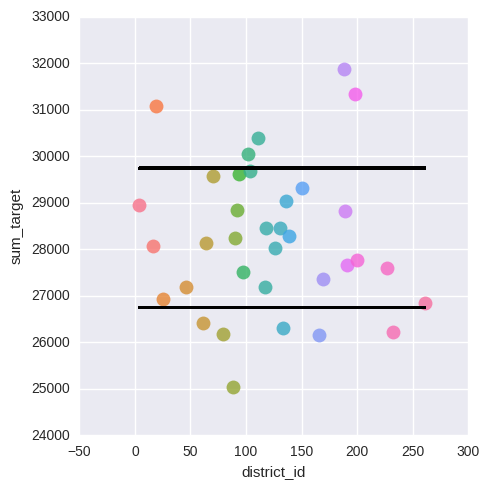

In [131]:
sns.lmplot(x='district_id',y='sum_target', hue='district_id', data=sum_target_by_district_id_LPU_19, legend=False, fit_reg=False,scatter_kws={"s": 100})
plt.plot(lower_bound['district_id'], lower_bound['goal_lpu_19'],color = 'black')
plt.plot(upper_bound['district_id'], upper_bound['goal_lpu_19'],color = 'black')

In [132]:
# Словарь, содержащий суммарные нагрузки по участкам 
loading = dict()
for district_id in lpu_19['district_id'].unique():
    loading[district_id]=sum(lpu_19['target'][lpu_19['district_id']==district_id])

In [133]:
%%time

#счётчик подсчёта перемещённых людей
counter_of_moving_people=0

#использую флаги состояний, говорящие о достижении равновесия
flags = pd.DataFrame({'district_id':lpu_19['district_id'].unique(),'balance?':np.zeros(lpu_19['district_id'].nunique())})

for mm in range(100000):                   #до этого было -- while True:, но так мы застраховываемся от зацикливания 
    #Участок с минимальной загрузкой
    key_min = min(loading, key=loading.get)
    MIN = loading[key_min]
    
    #Участок с максимальной загрузкой
    key_max = max(loading, key=loading.get)
    MAX = loading[key_max]
    
    #балансировка: переносим пациента с наибольшим target с участка максимальной загруженности
    #на участок c минимальной загруженностью 
    #на другой, пока не достигнем равновесия. 
    lpu_19_key_max = lpu_19[lpu_19['district_id'] == key_max]
    #Неприкасаемых не трогаем
    targets_with_key_max = lpu_19_key_max['target'][lpu_19_key_max['untouchable'] != 1]
    index_max_target = targets_with_key_max.idxmax()
    
    lpu_19.loc[index_max_target,'district_id'] = key_min
    counter_of_moving_people +=1
   
    #условие выхода из цикла: порог на количество перемещённых людей
    if counter_of_moving_people > 0.25*len(lpu_19):
        break
    
    #использую флаги состояний, говорящие о достижении равновесия
    for district_id in lpu_19['district_id'].unique():   
        #если суммарный target по данному участку находится в пределах погрешности балансного, целевого значения,то
        #флаг баланса по данному участку выставляем равным 1
        if abs(sum(lpu_19['target'][lpu_19['district_id'] == district_id]) - goal_lpu_19) < 1500:
            flags['balance?'][flags['district_id'] == district_id] = 1
    
    #условие выхода из цикла: все флаги равны 1, то есть все участки сбалансированы с заданной точностью
    if flags['balance?'].all():
        break
    
    flags['balance?'] = 0
    
    #Обновить словарь
    loading = dict()
    for district_id in lpu_19['district_id'].unique():
        loading[district_id]=sum(lpu_19['target'][lpu_19['district_id']==district_id])

CPU times: user 55.1 s, sys: 104 ms, total: 55.2 s
Wall time: 1min 1s


In [134]:
counter_of_moving_people

318

# Визуализация результатов балансировки по LPU_ID=19

In [135]:
#Cписок под хранение уникального значения district_id
district_id_lpu_19=[]
#Cписок под хранение cуммарного target по данному district_id
sum_target_lpu_19 = []
sum_target_by_district_id_LPU_19 = pd.DataFrame()
for district_id in lpu_19['district_id'].unique():
    district_id_lpu_19+=[district_id]
    sum_target_lpu_19+=[sum(lpu_19['target'][lpu_19['district_id']==district_id])]

sum_target_by_district_id_LPU_19['district_id']=district_id_lpu_19
sum_target_by_district_id_LPU_19['sum_target']=sum_target_lpu_19

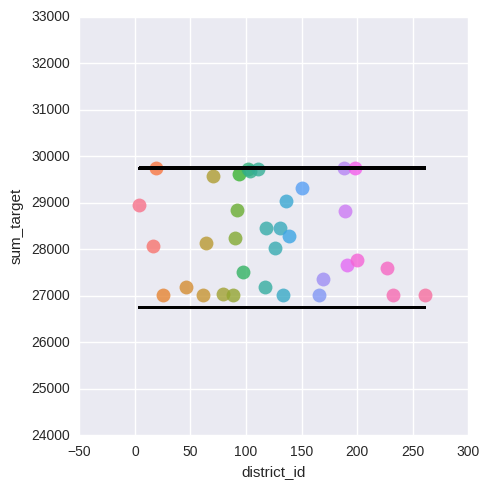

In [136]:
lm=sns.lmplot(x='district_id',y='sum_target', hue='district_id', data=sum_target_by_district_id_LPU_19, legend=False, fit_reg=False,scatter_kws={"s": 100})
lm.axes[0,0].set_ylim(24000,33000)
plt.plot(lower_bound['district_id'], lower_bound['goal_lpu_19'],color = 'black')
plt.plot(upper_bound['district_id'], upper_bound['goal_lpu_19'],color = 'black')